# LNM Group 1 - Prashant Kulkarni, Dharti Seagraves, Steve Veldman
## Final Project: Bank Account Fraud Detection
## Winter 2024

Link to Dataset on Kaggle:
https://www.kaggle.com/datasets/sgpjesus/bank-account-fraud-dataset-neurips-2022
(Our dataset is marked as "Base.csv" within the zip file)

# Import Libraries and Data:

In [ ]:
import time
# import beepy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import scipy
from scipy.cluster import hierarchy
from scipy.stats import pearsonr
import statsmodels.api as sm
# import shap
# import swifter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import imblearn
from sklearn.utils import shuffle


In [ ]:

from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/LNM Final - Winter 2024/Base.csv', low_memory=False)
# df = pd.read_csv('/content/Base.csv', low_memory=False)

Mounted at /content/drive


In [ ]:
df.head(20)
### Note: -1 means a missing value/null for many of the variables; we will need to figure out how to handle these

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,...,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,...,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,...,0,200.0,0,INTERNET,22.730559,windows,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,...,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,...,0,200.0,0,INTERNET,3.743048,other,0,1,0,0
5,0,0.6,0.294840,-1,369,30,0.024232,-1.232556,AD,1204,...,0,200.0,0,INTERNET,6.987316,linux,1,1,0,0
6,0,0.2,0.773085,22,4,40,0.006919,-0.544676,AB,1998,...,0,200.0,0,INTERNET,28.199923,x11,1,1,0,0
7,0,0.8,0.153880,-1,103,40,0.045122,-1.101184,AB,1548,...,1,200.0,0,INTERNET,11.234264,other,1,1,0,0
8,0,0.3,0.523655,21,2,30,0.035206,-0.955737,AB,1781,...,0,200.0,0,INTERNET,5.329387,other,1,1,0,0
9,0,0.8,0.834475,-1,134,20,0.017245,-1.356393,AD,3113,...,0,1500.0,0,INTERNET,4.103970,other,1,1,0,0


In [ ]:
df.prev_address_months_count.value_counts(sort=True)

-1      712920
 11      11475
 28      10275
 29      10150
 10      10082
         ...  
 374         1
 5           1
 375         1
 383         1
 381         1
Name: prev_address_months_count, Length: 374, dtype: int64

In [ ]:
df.current_address_months_count.value_counts(sort=True)

6      16376
7      16270
8      16089
5      15896
9      15688
       ...  
413        1
419        1
403        1
424        1
428        1
Name: current_address_months_count, Length: 423, dtype: int64

In [ ]:
df.loc[df['intended_balcon_amount'] < 0, 'intended_balcon_amount'] = -1
df.intended_balcon_amount.value_counts(sort=True)


-1.000000     742523
 36.848409         3
 26.364589         2
 27.196607         2
 38.415418         2
               ...  
 31.694135         1
 15.475984         1
 50.443999         1
 28.556870         1
 14.942456         1
Name: intended_balcon_amount, Length: 257138, dtype: int64

In [ ]:
df.bank_months_count.value_counts(sort=True)

-1     253635
 1     194802
 28     80082
 15     59141
 30     50777
 31     46084
 25     40450
 10     37158
 20     30850
 21     29098
 5      28001
 2      25836
 26     24779
 11     23745
 6      17678
 29     11696
 3       8580
 19      8212
 22      6741
 9       4801
 16      4563
 27      4197
 4       3834
 24      1822
 12      1121
 7        931
 14       493
 18       491
 23       320
 32        46
 8         30
 17         4
 13         2
Name: bank_months_count, dtype: int64

In [ ]:
df.session_length_in_minutes.value_counts(sort=True)
#drop NaN

-1.000000    2015
 9.661989       3
 7.960109       3
 4.192392       3
 2.463697       3
             ... 
 7.304219       1
 1.938174       1
 3.193973       1
 8.349347       1
 1.947926       1
Name: session_length_in_minutes, Length: 994887, dtype: int64

In [ ]:
condition = df['session_length_in_minutes'] == -1
df_filtered = df[-condition]
df_filtered.session_length_in_minutes.value_counts(sort=True)

4.743844     3
13.152597    3
4.192392     3
2.463697     3
5.101614     3
            ..
7.304219     1
1.938174     1
3.193973     1
8.349347     1
1.947926     1
Name: session_length_in_minutes, Length: 994886, dtype: int64

In [ ]:
df.device_distinct_emails_8w.value_counts(sort=True)
#Drop NaN

 1    968067
 2     25302
 0      6272
-1       359
Name: device_distinct_emails_8w, dtype: int64

In [ ]:
condition = df['device_distinct_emails_8w'] == -1
df_filtered = df[-condition]
df_filtered.device_distinct_emails_8w.value_counts(sort=True)

1    968067
2     25302
0      6272
Name: device_distinct_emails_8w, dtype: int64

In [ ]:
df.describe()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,...,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,...,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.0,1000000.000000
mean,0.011029,0.562696,0.493694,16.718568,86.587867,33.689080,1.025705e+00,8.676628,1572.692049,5665.296605,...,0.889676,10.839303,0.222988,515.851010,0.025242,7.544940,0.576947,1.018312,0.0,3.288674
std,0.104438,0.290343,0.289125,44.046230,88.406599,12.025799,5.381835e+00,20.225232,1005.374565,3009.380665,...,0.313293,12.116875,0.416251,487.559902,0.156859,8.033106,0.494044,0.180761,0.0,2.209994
min,0.000000,0.100000,0.000001,-1.000000,-1.000000,10.000000,4.036860e-09,-1.000000,1.000000,-170.603072,...,0.000000,-1.000000,0.000000,190.000000,0.000000,-1.000000,0.000000,-1.000000,0.0,0.000000
25%,0.000000,0.300000,0.225216,-1.000000,19.000000,20.000000,7.193246e-03,-1.000000,894.000000,3436.365848,...,1.000000,-1.000000,0.000000,200.000000,0.000000,3.103053,0.000000,1.000000,0.0,1.000000
50%,0.000000,0.600000,0.492153,-1.000000,52.000000,30.000000,1.517574e-02,-1.000000,1263.000000,5319.769349,...,1.000000,5.000000,0.000000,200.000000,0.000000,5.114321,1.000000,1.000000,0.0,3.000000
75%,0.000000,0.800000,0.755567,12.000000,130.000000,40.000000,2.633069e-02,4.984176,1944.000000,7680.717827,...,1.000000,25.000000,0.000000,500.000000,0.000000,8.866131,1.000000,1.000000,0.0,5.000000
max,1.000000,0.900000,0.999999,383.000000,428.000000,90.000000,7.845690e+01,112.956928,6700.000000,16715.565404,...,1.000000,32.000000,1.000000,2100.000000,1.000000,85.899143,1.000000,2.000000,0.0,7.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

In [ ]:
# df.drop_duplicates()
df.groupby(['fraud_bool'])['fraud_bool'].count()

fraud_bool
False    988971
True      11029
Name: fraud_bool, dtype: int64

# EDA:

<ipython-input-15-8597ee94f7f9>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_correlation = df.corr()


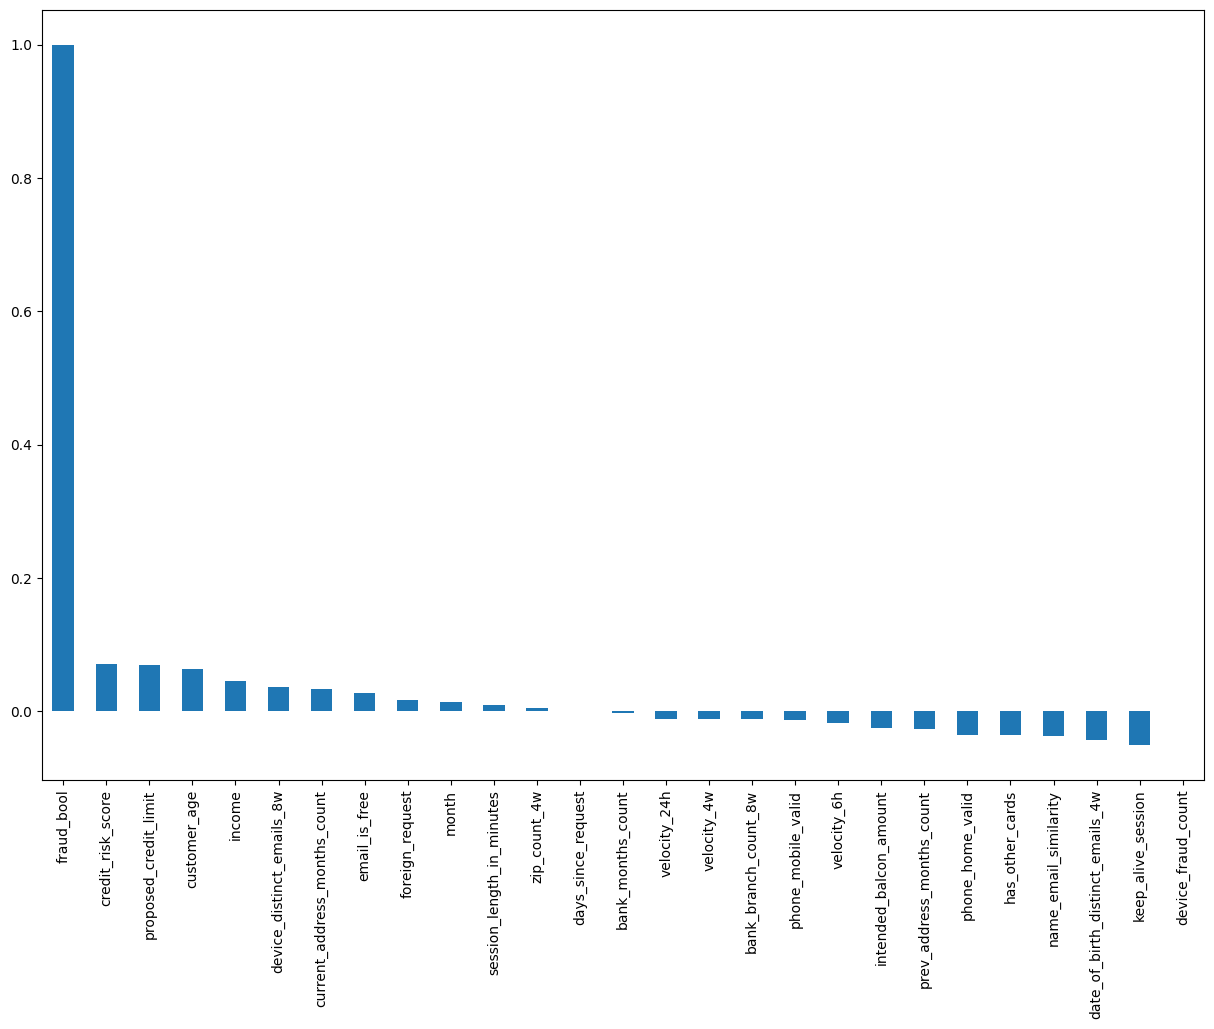

In [ ]:
df_correlation = df.corr()

plt.figure(figsize = (15,10))
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
df_correlation['fraud_bool'].sort_values(ascending = False).plot(kind = 'bar')
plt.show()

In [ ]:
# #convert binary to boolean:
# df['fraud_bool'] = df['fraud_bool'].astype('bool')
# df['email_is_free'] = df['email_is_free'].astype('bool')
# df['phone_home_valid'] = df['phone_home_valid'].astype('bool')
# df['phone_mobile_valid'] = df['phone_mobile_valid'].astype('bool')
# df['has_other_cards'] = df['has_other_cards'].astype('bool')
# df['foreign_request'] = df['foreign_request'].astype('bool')
# df['keep_alive_session'] = df['keep_alive_session'].astype('bool')

# Convert all columns of object dtype to category dtype
df.loc[:, df.select_dtypes(['object']).columns] = df.select_dtypes(['object']).apply(lambda x: x.astype('category'))

<ipython-input-16-3e5771cf2e7b>:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, df.select_dtypes(['object']).columns] = df.select_dtypes(['object']).apply(lambda x: x.astype('category'))


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype   
---  ------                            --------------    -----   
 0   fraud_bool                        1000000 non-null  int64   
 1   income                            1000000 non-null  float64 
 2   name_email_similarity             1000000 non-null  float64 
 3   prev_address_months_count         1000000 non-null  int64   
 4   current_address_months_count      1000000 non-null  int64   
 5   customer_age                      1000000 non-null  int64   
 6   days_since_request                1000000 non-null  float64 
 7   intended_balcon_amount            1000000 non-null  float64 
 8   payment_type                      1000000 non-null  category
 9   zip_count_4w                      1000000 non-null  int64   
 10  velocity_6h                       1000000 non-null  float64 
 11  velocity_24h             

In [ ]:
# Find columns with binary data
binary_columns = [col for col in df.columns if df[col].nunique() == 2]

print("Binary columns:", binary_columns)

Binary columns: ['fraud_bool', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'has_other_cards', 'foreign_request', 'source', 'keep_alive_session']


In [ ]:
# Iterate through each column and check if its dtype is 'object'
for col in df.columns:
    if df[col].dtype == 'category':
        print(f"Column: {col}")
        print("Distinct values:", df[col].unique())


Column: payment_type
Distinct values: ['AA', 'AD', 'AB', 'AC', 'AE']
Categories (5, object): ['AA', 'AB', 'AC', 'AD', 'AE']
Column: employment_status
Distinct values: ['CB', 'CA', 'CC', 'CF', 'CD', 'CE', 'CG']
Categories (7, object): ['CA', 'CB', 'CC', 'CD', 'CE', 'CF', 'CG']
Column: housing_status
Distinct values: ['BC', 'BE', 'BD', 'BA', 'BB', 'BF', 'BG']
Categories (7, object): ['BA', 'BB', 'BC', 'BD', 'BE', 'BF', 'BG']
Column: source
Distinct values: ['INTERNET', 'TELEAPP']
Categories (2, object): ['INTERNET', 'TELEAPP']
Column: device_os
Distinct values: ['linux', 'other', 'windows', 'x11', 'macintosh']
Categories (5, object): ['linux', 'macintosh', 'other', 'windows', 'x11']


In [ ]:
# Remove 'source' from the list if it exists
if 'source' in binary_columns:
    binary_columns.remove('source')

# Print the list after removal
print(binary_columns)

# Convert the specified columns in df to boolean
for col in binary_columns:
    df[col] = df[col].astype(bool)

# Check the result
df.head()

['fraud_bool', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'has_other_cards', 'foreign_request', 'keep_alive_session']


,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,False,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,...,False,1500.0,False,INTERNET,16.224843,linux,True,1,0,0
1,False,0.8,0.617426,-1,89,20,0.010095,-1.000000,AD,1658,...,False,1500.0,False,INTERNET,3.363854,other,True,1,0,0
2,False,0.8,0.996707,9,14,40,0.012316,-1.000000,AB,1095,...,False,200.0,False,INTERNET,22.730559,windows,False,1,0,0
3,False,0.6,0.475100,11,14,30,0.006991,-1.000000,AB,3483,...,False,200.0,False,INTERNET,15.215816,linux,True,1,0,0
4,False,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,...,False,200.0,False,INTERNET,3.743048,other,False,1,0,0


<ipython-input-21-356cefe5e592>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


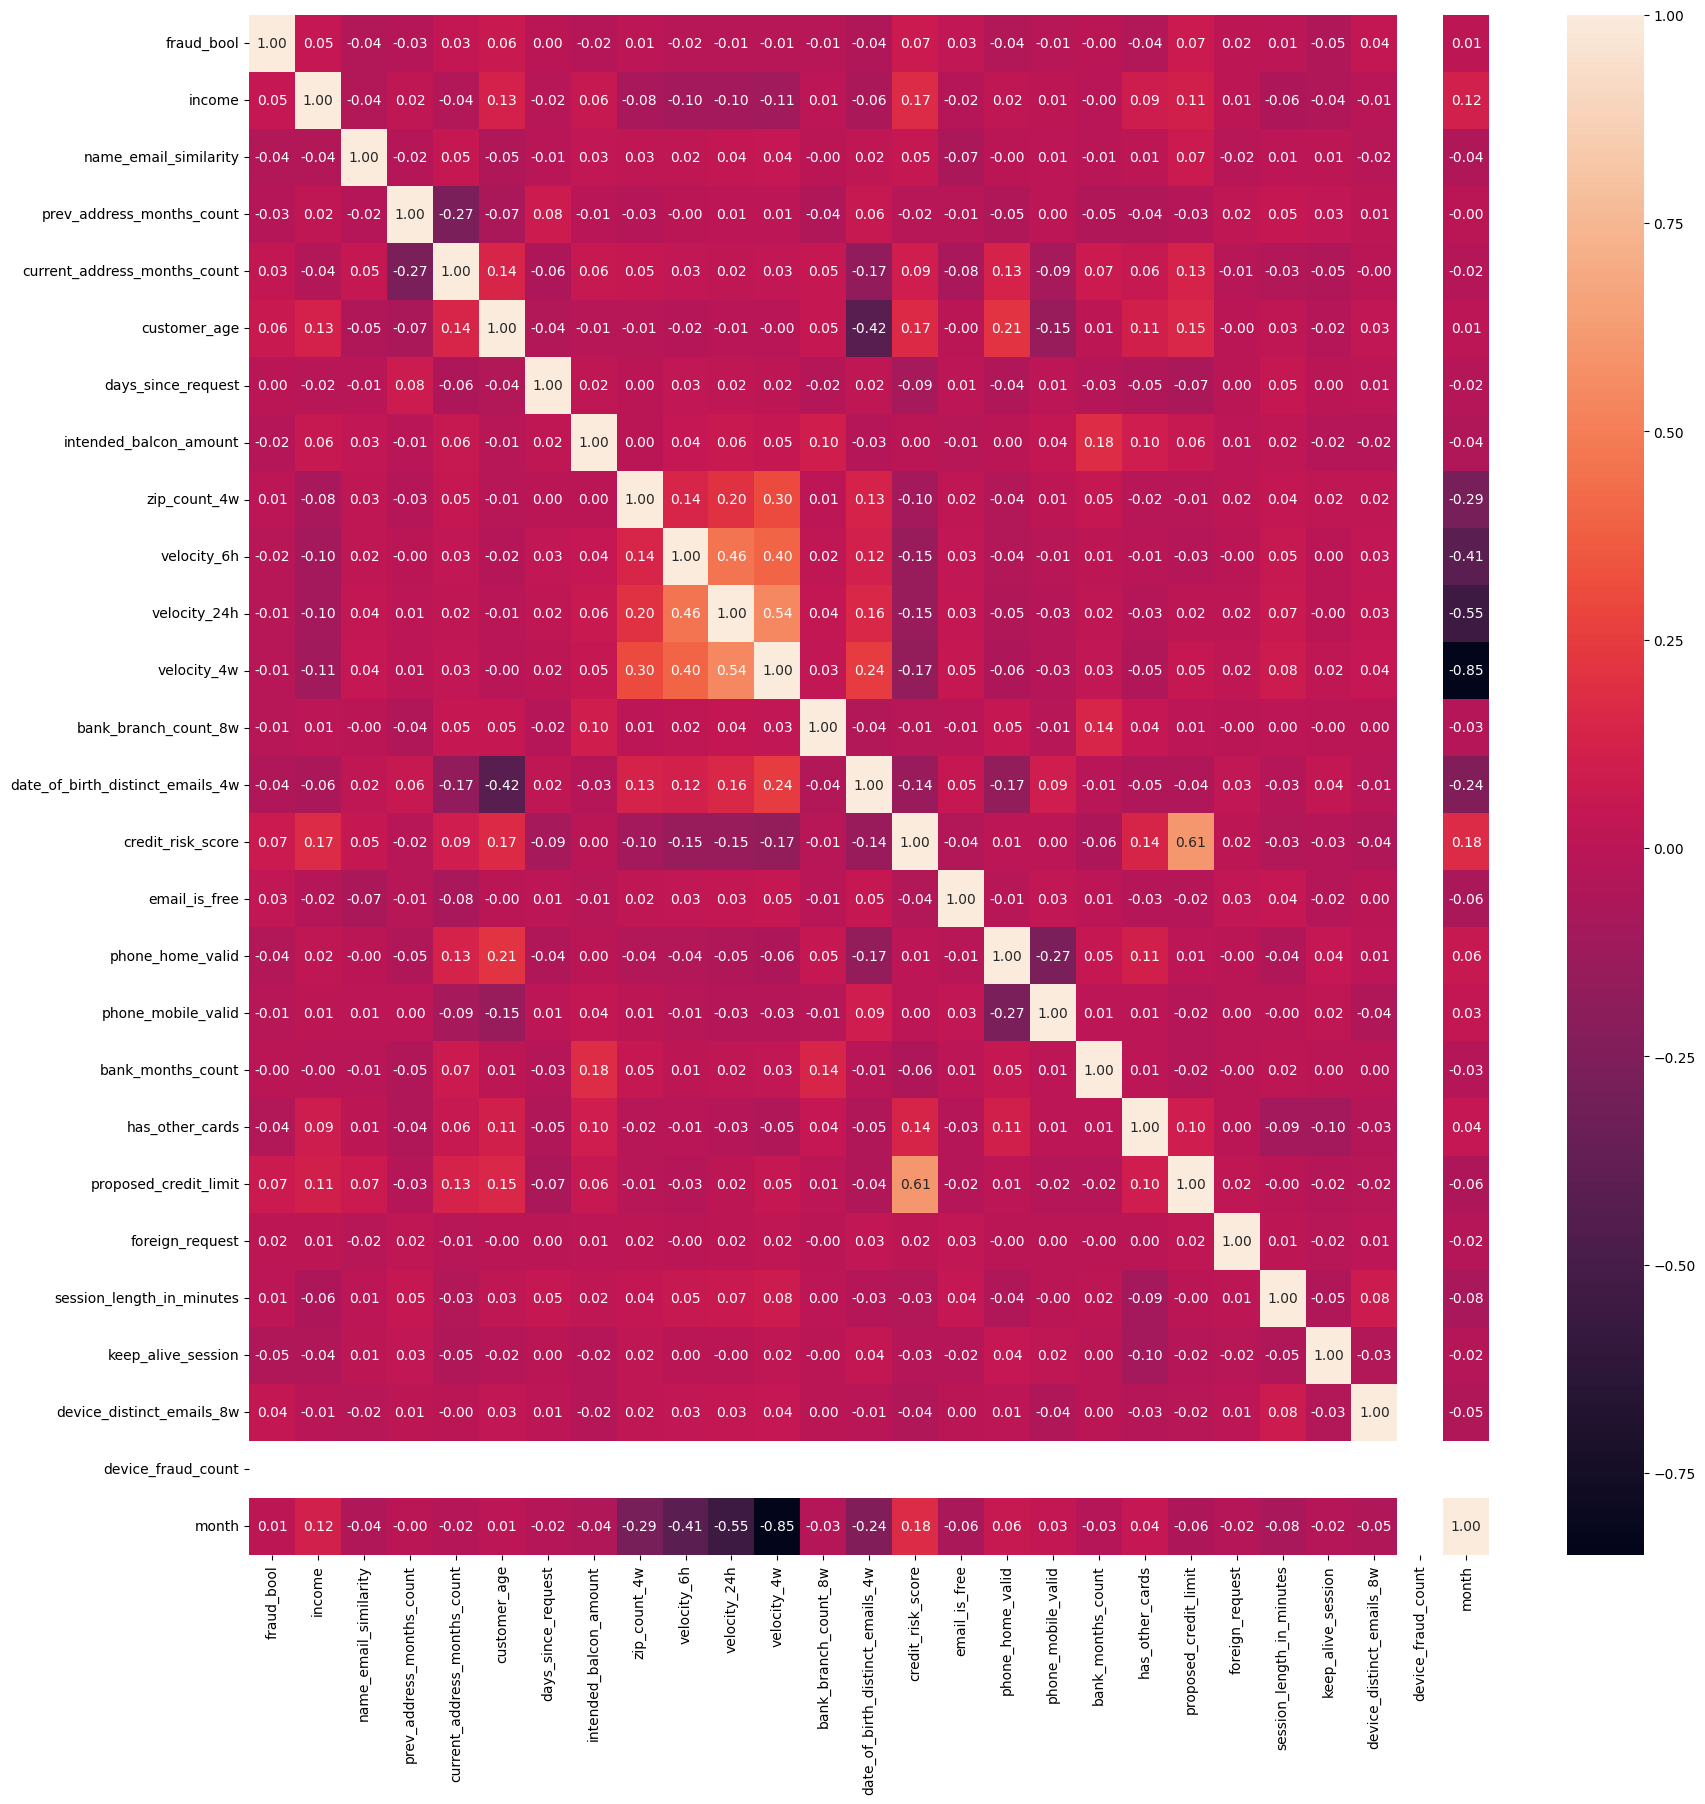

In [ ]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Set the figure size (width, height) in inches, e.g., (20, 20) for a large figure
plt.figure(figsize=(20, 20))

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f")

# Show the plot
# plt.savefig(f'LNM_Final/corrmatrix.png', dpi=300)
plt.show()

<Figure size 1700x1000 with 0 Axes>

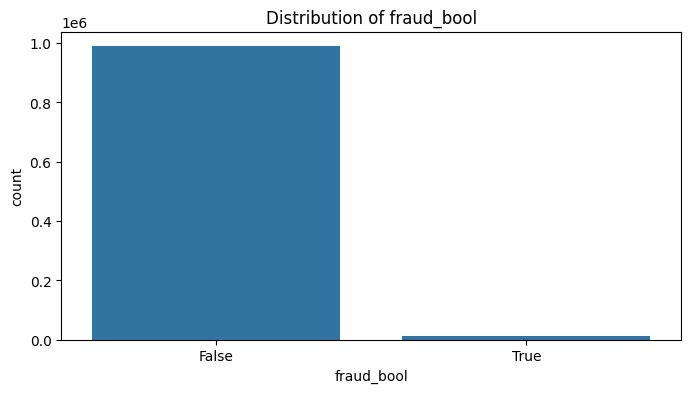

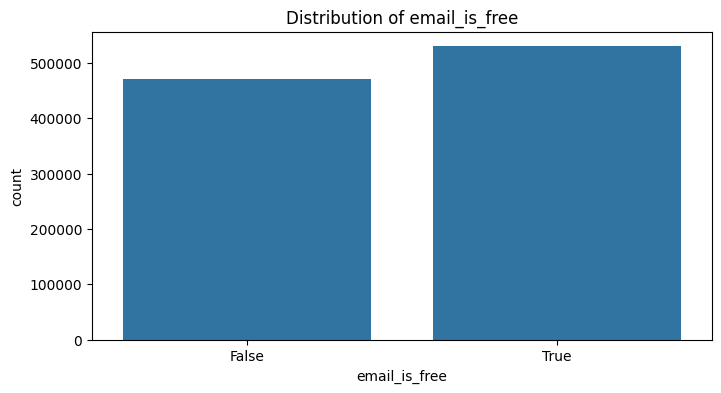

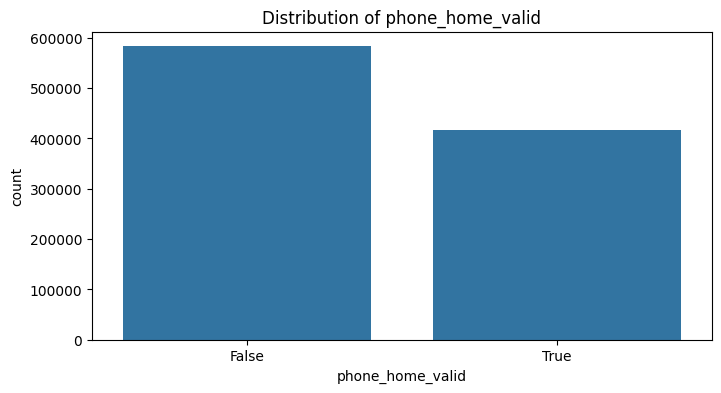

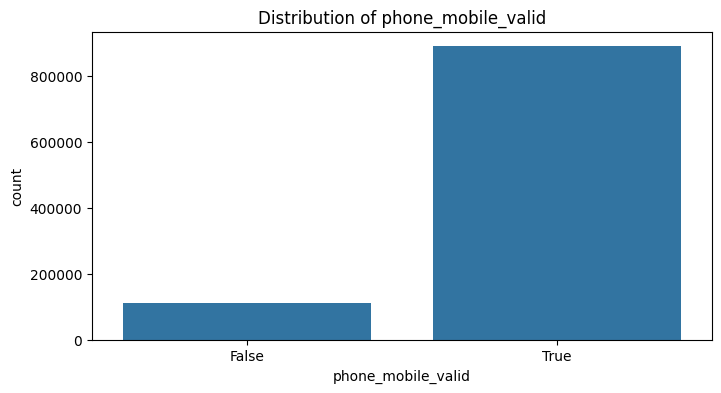

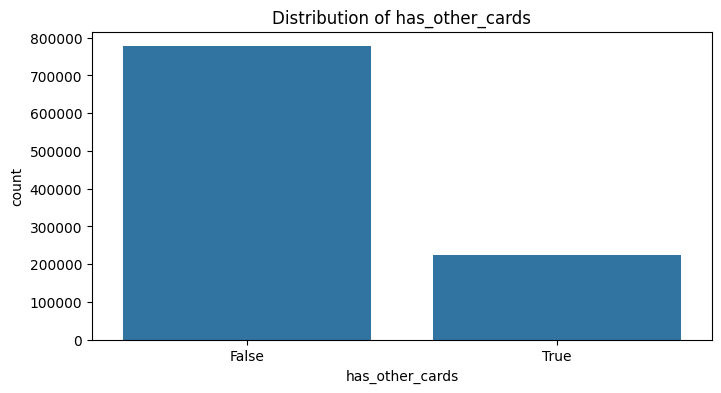

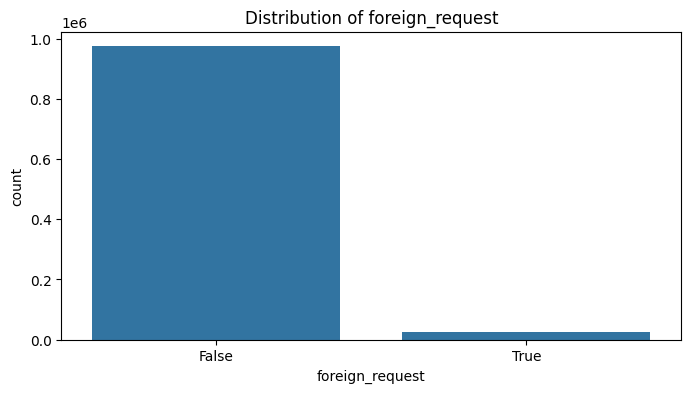

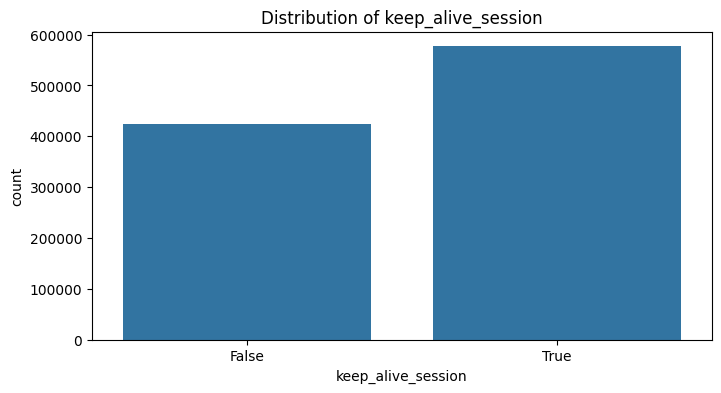

In [ ]:
plt.figure(figsize=(17,10))

# Plotting each binary column
for col in binary_columns:
    plt.figure(figsize=(8, 4))  # You can adjust the figure size as needed
    sns.countplot(x=df[col])
    plt.title(f'Distribution of {col}')

    # plt.savefig(f'LNM_Final/binary_{col}.png', dpi=300)
    plt.show()

In [ ]:
plt.figure(figsize=(17,10))

# Select non-numerical (object type) columns
non_numerical_columns = df.select_dtypes(include=['object']).columns

# Create a count plot for each categorical column
for col in non_numerical_columns:
    plt.figure(figsize=(10, 5))  # Adjust the size of the plot as needed
    sns.countplot(x=col, data=df)
    plt.title(f'Count Plot for {col}')
    plt.xticks(rotation=90)  # Rotate labels for better readability if needed

    # plt.savefig(f'LNM_Final/object_{col}.png', dpi=300)
    plt.show()

<Figure size 1700x1000 with 0 Axes>

## Alternate Initial EDA:

In [ ]:
# plt.figure(figsize=(17,10))

# plt.subplot(231)
# catsFraud = df['fraud_bool'].value_counts().index
# cntsFraud = df['fraud_bool'].value_counts().values
# plt.bar(catsFraud, cntsFraud, width=0.5)
# plt.xlabel('Fraud')
# plt.xticks(ticks = (0,1), labels = ('No', 'Yes'))

# plt.subplot(232)
# catsPT = df['payment_type'].value_counts().index
# cntsPT = df['payment_type'].value_counts().values
# plt.bar(catsPT, cntsPT, width=0.5)
# plt.xlabel('Payment Type ')

# plt.subplot(233)
# catsES = df['employment_status'].value_counts().index
# cntsES = df['employment_status'].value_counts().values
# plt.bar(catsES, cntsES, width=0.5)
# plt.xlabel('Employment Status')

# plt.subplot(234)
# catsHS = df['housing_status'].value_counts().index.astype(object)
# cntsHS = df['housing_status'].value_counts().values
# plt.bar(catsHS, cntsHS, width=0.5)
# plt.xlabel('Housing Status')

# plt.subplot(235)
# catsS = df['source'].value_counts().index
# cntsS = df['source'].value_counts().values
# plt.bar(catsS, cntsS, width=0.5)
# plt.xlabel('Source')

# plt.subplot(236)
# catsDOS = df['device_os'].value_counts().index
# cntsDOS = df['device_os'].value_counts().values
# plt.bar(catsDOS, cntsDOS, width=0.5)
# plt.xlabel('Device OS')

# plt.tight_layout(w_pad=6);

In [ ]:
# plt.figure(figsize=(17,10))

# plt.subplot(231)
# catsEF = df['email_is_free'].value_counts().index
# cntsEF = df['email_is_free'].value_counts().values
# plt.bar(catsEF, cntsEF, width=0.5)
# plt.xlabel('Email is Free')
# plt.xticks(ticks = (0,1), labels = ('No', 'Yes'))

# plt.subplot(232)
# catsHP = df['phone_home_valid'].value_counts().index
# cntsHP = df['phone_home_valid'].value_counts().values
# plt.bar(catsHP, cntsHP, width=0.5)
# plt.xlabel('Home Phone Valid')
# plt.xticks(ticks = (0,1), labels = ('No', 'Yes'))

# plt.subplot(233)
# catsMP = df['phone_mobile_valid'].value_counts().index
# cntsMP = df['phone_mobile_valid'].value_counts().values
# plt.bar(catsMP, cntsMP, width=0.5)
# plt.xlabel('Mobile Phone Valid')
# plt.xticks(ticks = (0,1), labels = ('No', 'Yes'))

# plt.subplot(234)
# catsOC = df['has_other_cards'].value_counts().index.astype(object)
# cntsOC = df['has_other_cards'].value_counts().values
# plt.bar(catsOC, cntsOC, width=0.5)
# plt.xlabel('Has Other Cards')
# plt.xticks(ticks = (0,1), labels = ('No', 'Yes'))

# plt.subplot(235)
# catsFR = df['foreign_request'].value_counts().index
# cntsFR = df['foreign_request'].value_counts().values
# plt.bar(catsFR, cntsFR, width=0.5)
# plt.xlabel('Foreign Request')
# plt.xticks(ticks = (0,1), labels = ('No', 'Yes'))

# plt.subplot(236)
# catsKAS = df['keep_alive_session'].value_counts().index
# cntsKAS = df['keep_alive_session'].value_counts().values
# plt.bar(catsKAS, cntsKAS, width=0.5)
# plt.xlabel('Keep Alive Session')
# plt.xticks(ticks = (0,1), labels = ('No', 'Yes'))

# plt.tight_layout(w_pad=6);

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype   
---  ------                            --------------    -----   
 0   fraud_bool                        1000000 non-null  bool    
 1   income                            1000000 non-null  float64 
 2   name_email_similarity             1000000 non-null  float64 
 3   prev_address_months_count         1000000 non-null  int64   
 4   current_address_months_count      1000000 non-null  int64   
 5   customer_age                      1000000 non-null  int64   
 6   days_since_request                1000000 non-null  float64 
 7   intended_balcon_amount            1000000 non-null  float64 
 8   payment_type                      1000000 non-null  category
 9   zip_count_4w                      1000000 non-null  int64   
 10  velocity_6h                       1000000 non-null  float64 
 11  velocity_24h             

# Variable Selection and Preprocessing:

## Downsampling:
Due to the size of this dataset, we would ideally take a random sample of 25% of the data (250k observations).
Because we do not want to lose any of the minorty class ("fraud_bool" == True) observations, we are going to preserve all of those.
The rest of our data dataset will be a random sample of the majority class, and the data imbalance issue will be "properly" treated later in the process.

In [ ]:
# Downsampling:

# Save a copy of the full dataset, which will be used later for the Random Undersampling data balancing technique
df_full = df

# Separate the two classes:
df_fraud = df[df['fraud_bool'] == 1]
df_not_fraud = df[df['fraud_bool'] == 0]

# Extract random sample of negative class:
df_sample = df_not_fraud.sample(n = (250000 - len(df_fraud)), random_state = 42)

# Re-assemble and shuffle the rows:
df = shuffle(df_sample.append(df_fraud), random_state = 42)

# Reset Index:
df.reset_index(inplace = True, drop = True)

df.head()

<ipython-input-33-77da2efc94b9>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = shuffle(df_sample.append(df_fraud), random_state = 42)


,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.1,0.197097,-1,95,40,0.010848,-1.000000,AA,3146,...,0,200.0,0,INTERNET,4.675774,other,1,1,0,5
1,0,0.4,0.901759,-1,135,30,0.003467,53.510466,AA,870,...,1,200.0,0,INTERNET,2.559203,other,0,1,0,7
2,0,0.4,0.882841,-1,78,30,0.015890,50.330770,AA,1501,...,0,200.0,0,INTERNET,5.173118,macintosh,0,1,0,0
3,0,0.9,0.685043,-1,192,40,0.004599,38.380630,AA,463,...,1,200.0,0,INTERNET,3.402366,other,0,1,0,6
4,0,0.1,0.796564,345,50,30,0.002983,101.201994,AB,1248,...,0,1000.0,0,INTERNET,5.498118,windows,1,1,0,2


In [ ]:
# Choosing the appropriate variables

var_cols = ['income', 'name_email_similarity',
        'prev_address_months_count', 'current_address_months_count',
        'customer_age', 'days_since_request', 'intended_balcon_amount',
        'payment_type', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
        'velocity_4w', 'bank_branch_count_8w',
        'date_of_birth_distinct_emails_4w', 'employment_status',
        'credit_risk_score', 'email_is_free', 'housing_status',
        'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
        'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
        'session_length_in_minutes', 'device_os', 'keep_alive_session',
        'device_distinct_emails_8w', 'device_fraud_count', 'month']

#var_cols = ['income','date_of_birth_distinct_emails_4w',
#       'credit_risk_score', 'proposed_credit_limit']

In [ ]:
# Convert all columns of object dtype to category dtype
df.loc[:, df.select_dtypes(['object']).columns] = df.select_dtypes(['object']).apply(lambda x: x.astype('category'))

In [ ]:
# Splitting Train/Test

In [ ]:
# Separate the features and the target variable
X = df[var_cols]
# X = df.drop('fraud_bool', axis=1)  # Replace with your actual target column name
y = df['fraud_bool']  # Replace with your actual target column name

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

# Create transformers for numerical and categorical data
# numerical_transformer = StandardScaler()
# categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Bundle preprocessing for numerical and categorical data
# preprocessor = ColumnTransformer(
#    transformers=[
#        ('num', numerical_transformer, numerical_cols),
#        ('cat', categorical_transformer, categorical_cols)
#    ])

# Apply the preprocessing pipeline to the training data
# X_train_prepared = preprocessor.fit_transform(X_train)
# X_test_prepared = preprocessor.transform(X_test)

## Data Imbalance: Random Undersampling, SMOTE, and SMOTE-ENN:

In [ ]:
# Encoding X-train categorical variables (needed for SMOTE and SMOTE-ENN to work with categorical features):
from sklearn.preprocessing import LabelEncoder

X_train_encoded = X_train.copy()

class_encoder = LabelEncoder()
X_train_encoded["payment_type"] = class_encoder.fit_transform(X_train_encoded["payment_type"])
X_train_encoded["employment_status"] = class_encoder.fit_transform(X_train_encoded["employment_status"])
X_train_encoded["housing_status"] = class_encoder.fit_transform(X_train_encoded["housing_status"])
X_train_encoded["device_os"] = class_encoder.fit_transform(X_train_encoded["device_os"])
X_train_encoded["source"] = class_encoder.fit_transform(X_train_encoded["source"])

In [ ]:
X_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800000 entries, 39111 to 228494
Data columns (total 31 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   income                            800000 non-null  float64
 1   name_email_similarity             800000 non-null  float64
 2   prev_address_months_count         800000 non-null  int64  
 3   current_address_months_count      800000 non-null  int64  
 4   customer_age                      800000 non-null  int64  
 5   days_since_request                800000 non-null  float64
 6   intended_balcon_amount            800000 non-null  float64
 7   payment_type                      800000 non-null  int64  
 8   zip_count_4w                      800000 non-null  int64  
 9   velocity_6h                       800000 non-null  float64
 10  velocity_24h                      800000 non-null  float64
 11  velocity_4w                       800000 non-nul

In [ ]:
# Create SMOTE-balanced train and test sets:
smt = imblearn.over_sampling.SMOTE(sampling_strategy='minority', random_state=42)
smt_train_x, smt_train_y = smt.fit_resample(X_train_encoded, y_train)

# SMOTE-ENN:
# First define ENN object - here we may want to experiment with the parameters sampling_strategy ('all' vs 'auto') and n_neighbors (3 is default):
our_enn = imblearn.under_sampling.EditedNearestNeighbours(sampling_strategy = 'auto', n_neighbors = 3)

# Create SMOTE-ENN balanced train and test sets:
senn = imblearn.combine.SMOTEENN(sampling_strategy='minority', random_state=42, enn = our_enn)
senn_train_x, senn_train_y = senn.fit_resample(X_train_encoded, y_train)


In [ ]:
# Decode SMOTE and SMOTE-ENN training sets back to categorical features:
smt_train_x_decode = smt_train_x.copy()
senn_train_x_decode = senn_train_x.copy()

In [ ]:
payment_type_enc = pd.DataFrame(X_train_encoded['payment_type'].value_counts())
payment_type_enc = payment_type_enc.index.values.tolist()

payment_type_orig = pd.DataFrame(X_train['payment_type'].value_counts())
payment_type_orig = payment_type_orig.index.values.tolist()

payment_type_key = pd.DataFrame()
payment_type_key['payment_type_enc'] = payment_type_enc
payment_type_key['payment_type_orig'] = payment_type_orig

print(payment_type_key)

   payment_type_enc payment_type_orig
0                 1                AB
1                 0                AA
2                 2                AC
3                 3                AD
4                 4                AE


In [ ]:
smt_train_x_decode.loc[smt_train_x_decode.payment_type == 1, 'payment_type'] = "AB"
smt_train_x_decode.loc[smt_train_x_decode.payment_type == 2, 'payment_type'] = "AC"
smt_train_x_decode.loc[smt_train_x_decode.payment_type == 0, 'payment_type'] = "AA"
smt_train_x_decode.loc[smt_train_x_decode.payment_type == 3, 'payment_type'] = "AD"
smt_train_x_decode.loc[smt_train_x_decode.payment_type == 4, 'payment_type'] = "AE"

senn_train_x_decode.loc[senn_train_x_decode.payment_type == 1, 'payment_type'] = "AB"
senn_train_x_decode.loc[senn_train_x_decode.payment_type == 2, 'payment_type'] = "AC"
senn_train_x_decode.loc[senn_train_x_decode.payment_type == 0, 'payment_type'] = "AA"
senn_train_x_decode.loc[senn_train_x_decode.payment_type == 3, 'payment_type'] = "AD"
senn_train_x_decode.loc[senn_train_x_decode.payment_type == 4, 'payment_type'] = "AE"

In [ ]:
housing_status_enc = pd.DataFrame(X_train_encoded['housing_status'].value_counts())
housing_status_enc = housing_status_enc.index.values.tolist()

housing_status_orig = pd.DataFrame(X_train['housing_status'].value_counts())
housing_status_orig = housing_status_orig.index.values.tolist()

housing_status_key = pd.DataFrame()
housing_status_key['housing_status_enc'] = housing_status_enc
housing_status_key['housing_status_orig'] = housing_status_orig

print(housing_status_key)

   housing_status_enc housing_status_orig
0                   2                  BC
1                   1                  BB
2                   0                  BA
3                   4                  BE
4                   3                  BD
5                   5                  BF
6                   6                  BG


In [ ]:
smt_train_x_decode.loc[smt_train_x_decode.housing_status == 2, 'housing_status'] = "BC"
smt_train_x_decode.loc[smt_train_x_decode.housing_status == 1, 'housing_status'] = "BB"
smt_train_x_decode.loc[smt_train_x_decode.housing_status == 0, 'housing_status'] = "BA"
smt_train_x_decode.loc[smt_train_x_decode.housing_status == 4, 'housing_status'] = "BE"
smt_train_x_decode.loc[smt_train_x_decode.housing_status == 3, 'housing_status'] = "BD"
smt_train_x_decode.loc[smt_train_x_decode.housing_status == 5, 'housing_status'] = "BF"
smt_train_x_decode.loc[smt_train_x_decode.housing_status == 6, 'housing_status'] = "BG"

senn_train_x_decode.loc[senn_train_x_decode.housing_status == 2, 'housing_status'] = "BC"
senn_train_x_decode.loc[senn_train_x_decode.housing_status == 1, 'housing_status'] = "BB"
senn_train_x_decode.loc[senn_train_x_decode.housing_status == 0, 'housing_status'] = "BA"
senn_train_x_decode.loc[senn_train_x_decode.housing_status == 4, 'housing_status'] = "BE"
senn_train_x_decode.loc[senn_train_x_decode.housing_status == 3, 'housing_status'] = "BD"
senn_train_x_decode.loc[senn_train_x_decode.housing_status == 5, 'housing_status'] = "BF"
senn_train_x_decode.loc[senn_train_x_decode.housing_status == 6, 'housing_status'] = "BG"

In [ ]:
employment_status_enc = pd.DataFrame(X_train_encoded['employment_status'].value_counts())
employment_status_enc = employment_status_enc.index.values.tolist()

employment_status_orig = pd.DataFrame(X_train['employment_status'].value_counts())
employment_status_orig = employment_status_orig.index.values.tolist()

employment_status_key = pd.DataFrame()
employment_status_key['employment_status_enc'] = employment_status_enc
employment_status_key['employment_status_orig'] = employment_status_orig

print(employment_status_key)

   employment_status_enc employment_status_orig
0                      0                     CA
1                      1                     CB
2                      5                     CF
3                      2                     CC
4                      3                     CD
5                      4                     CE
6                      6                     CG


In [ ]:
smt_train_x_decode.loc[smt_train_x_decode.employment_status == 0, 'employment_status'] = "CA"
smt_train_x_decode.loc[smt_train_x_decode.employment_status == 1, 'employment_status'] = "CB"
smt_train_x_decode.loc[smt_train_x_decode.employment_status == 5, 'employment_status'] = "CF"
smt_train_x_decode.loc[smt_train_x_decode.employment_status == 2, 'employment_status'] = "CC"
smt_train_x_decode.loc[smt_train_x_decode.employment_status == 3, 'employment_status'] = "CD"
smt_train_x_decode.loc[smt_train_x_decode.employment_status == 4, 'employment_status'] = "CE"
smt_train_x_decode.loc[smt_train_x_decode.employment_status == 6, 'employment_status'] = "CG"

senn_train_x_decode.loc[senn_train_x_decode.employment_status == 0, 'employment_status'] = "CA"
senn_train_x_decode.loc[senn_train_x_decode.employment_status == 1, 'employment_status'] = "CB"
senn_train_x_decode.loc[senn_train_x_decode.employment_status == 5, 'employment_status'] = "CF"
senn_train_x_decode.loc[senn_train_x_decode.employment_status == 2, 'employment_status'] = "CC"
senn_train_x_decode.loc[senn_train_x_decode.employment_status == 3, 'employment_status'] = "CD"
senn_train_x_decode.loc[senn_train_x_decode.employment_status == 4, 'employment_status'] = "CE"
senn_train_x_decode.loc[senn_train_x_decode.employment_status == 6, 'employment_status'] = "CG"

In [ ]:
source_enc = pd.DataFrame(X_train_encoded['source'].value_counts())
source_enc = source_enc.index.values.tolist()

source_orig = pd.DataFrame(X_train['source'].value_counts())
source_orig = source_orig.index.values.tolist()

source_key = pd.DataFrame()
source_key['source_enc'] = source_enc
source_key['source_orig'] = source_orig

print(source_key)

   source_enc source_orig
0           0    INTERNET
1           1     TELEAPP


In [ ]:
smt_train_x_decode.loc[smt_train_x_decode.source == 0, 'source'] = "INTERNET"
smt_train_x_decode.loc[smt_train_x_decode.source == 1, 'source'] = "TELEAPP"

senn_train_x_decode.loc[senn_train_x_decode.source == 0, 'source'] = "INTERNET"
senn_train_x_decode.loc[senn_train_x_decode.source == 1, 'source'] = "TELEAPP"

In [ ]:
device_os_enc = pd.DataFrame(X_train_encoded['device_os'].value_counts())
device_os_enc = device_os_enc.index.values.tolist()

device_os_orig = pd.DataFrame(X_train['device_os'].value_counts())
device_os_orig = device_os_orig.index.values.tolist()

device_os_key = pd.DataFrame()
device_os_key['device_os_enc'] = device_os_enc
device_os_key['device_os_orig'] = device_os_orig

print(device_os_key)

   device_os_enc device_os_orig
0              2          other
1              0          linux
2              3        windows
3              1      macintosh
4              4            x11


In [ ]:
smt_train_x_decode.loc[smt_train_x_decode.device_os == 2, 'device_os'] = "other"
smt_train_x_decode.loc[smt_train_x_decode.device_os == 0, 'device_os'] = "linux"
smt_train_x_decode.loc[smt_train_x_decode.device_os == 3, 'device_os'] = "windows"
smt_train_x_decode.loc[smt_train_x_decode.device_os == 1, 'device_os'] = "macintosh"
smt_train_x_decode.loc[smt_train_x_decode.device_os == 4, 'device_os'] = "x11"

senn_train_x_decode.loc[senn_train_x_decode.employment_status == 2, 'device_os'] = "other"
senn_train_x_decode.loc[senn_train_x_decode.employment_status == 0, 'device_os'] = "linux"
senn_train_x_decode.loc[senn_train_x_decode.employment_status == 3, 'device_os'] = "windows"
senn_train_x_decode.loc[senn_train_x_decode.employment_status == 1, 'device_os'] = "macintosh"
senn_train_x_decode.loc[senn_train_x_decode.employment_status == 4, 'device_os'] = "x11"


In [ ]:
# Convert all columns of object dtype to category dtype
senn_train_x_decode.loc[:, senn_train_x_decode.select_dtypes(['object']).columns] = senn_train_x_decode.select_dtypes(['object']).apply(lambda x: x.astype('category'))
smt_train_x_decode.loc[:, smt_train_x_decode.select_dtypes(['object']).columns] = smt_train_x_decode.select_dtypes(['object']).apply(lambda x: x.astype('category'))

<ipython-input-57-20e851542a49>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  senn_train_x_decode.loc[:, senn_train_x_decode.select_dtypes(['object']).columns] = senn_train_x_decode.select_dtypes(['object']).apply(lambda x: x.astype('category'))


In [ ]:
# Return decoded datasets back to original names:
senn_train_x = senn_train_x_decode
smt_train_x = smt_train_x_decode

senn_train_x.info()
smt_train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1580309 entries, 0 to 1580308
Data columns (total 31 columns):
 #   Column                            Non-Null Count    Dtype   
---  ------                            --------------    -----   
 0   income                            1580309 non-null  float64 
 1   name_email_similarity             1580309 non-null  float64 
 2   prev_address_months_count         1580309 non-null  int64   
 3   current_address_months_count      1580309 non-null  int64   
 4   customer_age                      1580309 non-null  int64   
 5   days_since_request                1580309 non-null  float64 
 6   intended_balcon_amount            1580309 non-null  float64 
 7   payment_type                      1580309 non-null  category
 8   zip_count_4w                      1580309 non-null  int64   
 9   velocity_6h                       1580309 non-null  float64 
 10  velocity_24h                      1580309 non-null  float64 
 11  velocity_4w             

In [ ]:
# Create RU-balanced train and test sets:
# Note for this process we go back to the entire dataset to take our sample of the majority class

X_full = df_full.drop('fraud_bool', axis=1)
y_full = df_full['fraud_bool']

# Split the dataset into training and testing sets
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y_full, test_size=0.2, random_state=42, stratify=y_full)

rus = imblearn.under_sampling.RandomUnderSampler(sampling_strategy='majority', random_state=7, replacement=False)
rus_train_x, rus_train_y = rus.fit_resample(X_train_full, y_train_full)

In [ ]:
# Combine X_train and y_train into dictionaries
dataset_test = {'X_test': X_test, 'y_test': y_test}

dataset_train_original = {'X_train': X_train, 'y_train': y_train}

dataset_smt_train = {'X_train': smt_train_x, 'y_train': smt_train_y}

dataset_senn_train = {'X_train': senn_train_x, 'y_train': senn_train_y}

dataset_rus_train = {'X_train': rus_train_x, 'y_train': rus_train_y}

In [ ]:
# Export
import pickle

# Save the dataset to a pickle file
with open('/content/drive/MyDrive/LNM Final - Winter 2024/bank_fraud_test_set.pkl', 'wb') as file:
    pickle.dump(dataset_test, file)
with open('/content/drive/MyDrive/LNM Final - Winter 2024/bank_fraud_train_set_natural.pkl', 'wb') as file:
    pickle.dump(dataset_train_original, file)
with open('/content/drive/MyDrive/LNM Final - Winter 2024/bank_fraud_train_set_smote.pkl', 'wb') as file:
    pickle.dump(dataset_smt_train, file)
with open('/content/drive/MyDrive/LNM Final - Winter 2024/bank_fraud_train_set_smote_enn.pkl', 'wb') as file:
    pickle.dump(dataset_senn_train, file)
with open('/content/drive/MyDrive/LNM Final - Winter 2024/fraud_train_set_rus.pkl', 'wb') as file:
    pickle.dump(dataset_rus_train, file)